In [1]:
import os
import dataset
from stuf import stuf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk', font_scale=0.9, rc={"lines.linewidth": 2.5})
from pyleaves.datasets import leaves_dataset, fossil_dataset, pnas_dataset, base_dataset

PARAMS = {'threshold':2}
PARAMS['exclude_classes'] = ['notcataloged','notcatalogued', 'II. IDs, families uncertain', 'Unidentified']

In [2]:
# datasets = {
#         'PNAS': pnas_dataset.PNASDataset(),
#         'Leaves': leaves_dataset.LeavesDataset(),
#         'Fossil': fossil_dataset.FossilDataset()
#         }
# data_files = datasets[dataset_name]

# data_files.exclude_rare_classes(threshold=threshold)
# encoder = base_dataset.LabelEncoder(data_files.classes)
# classes = list(set(encoder.classes)-set(exclude_classes))
# data_files, excluded_data_files = data_files.enforce_class_whitelist(class_names=classes)

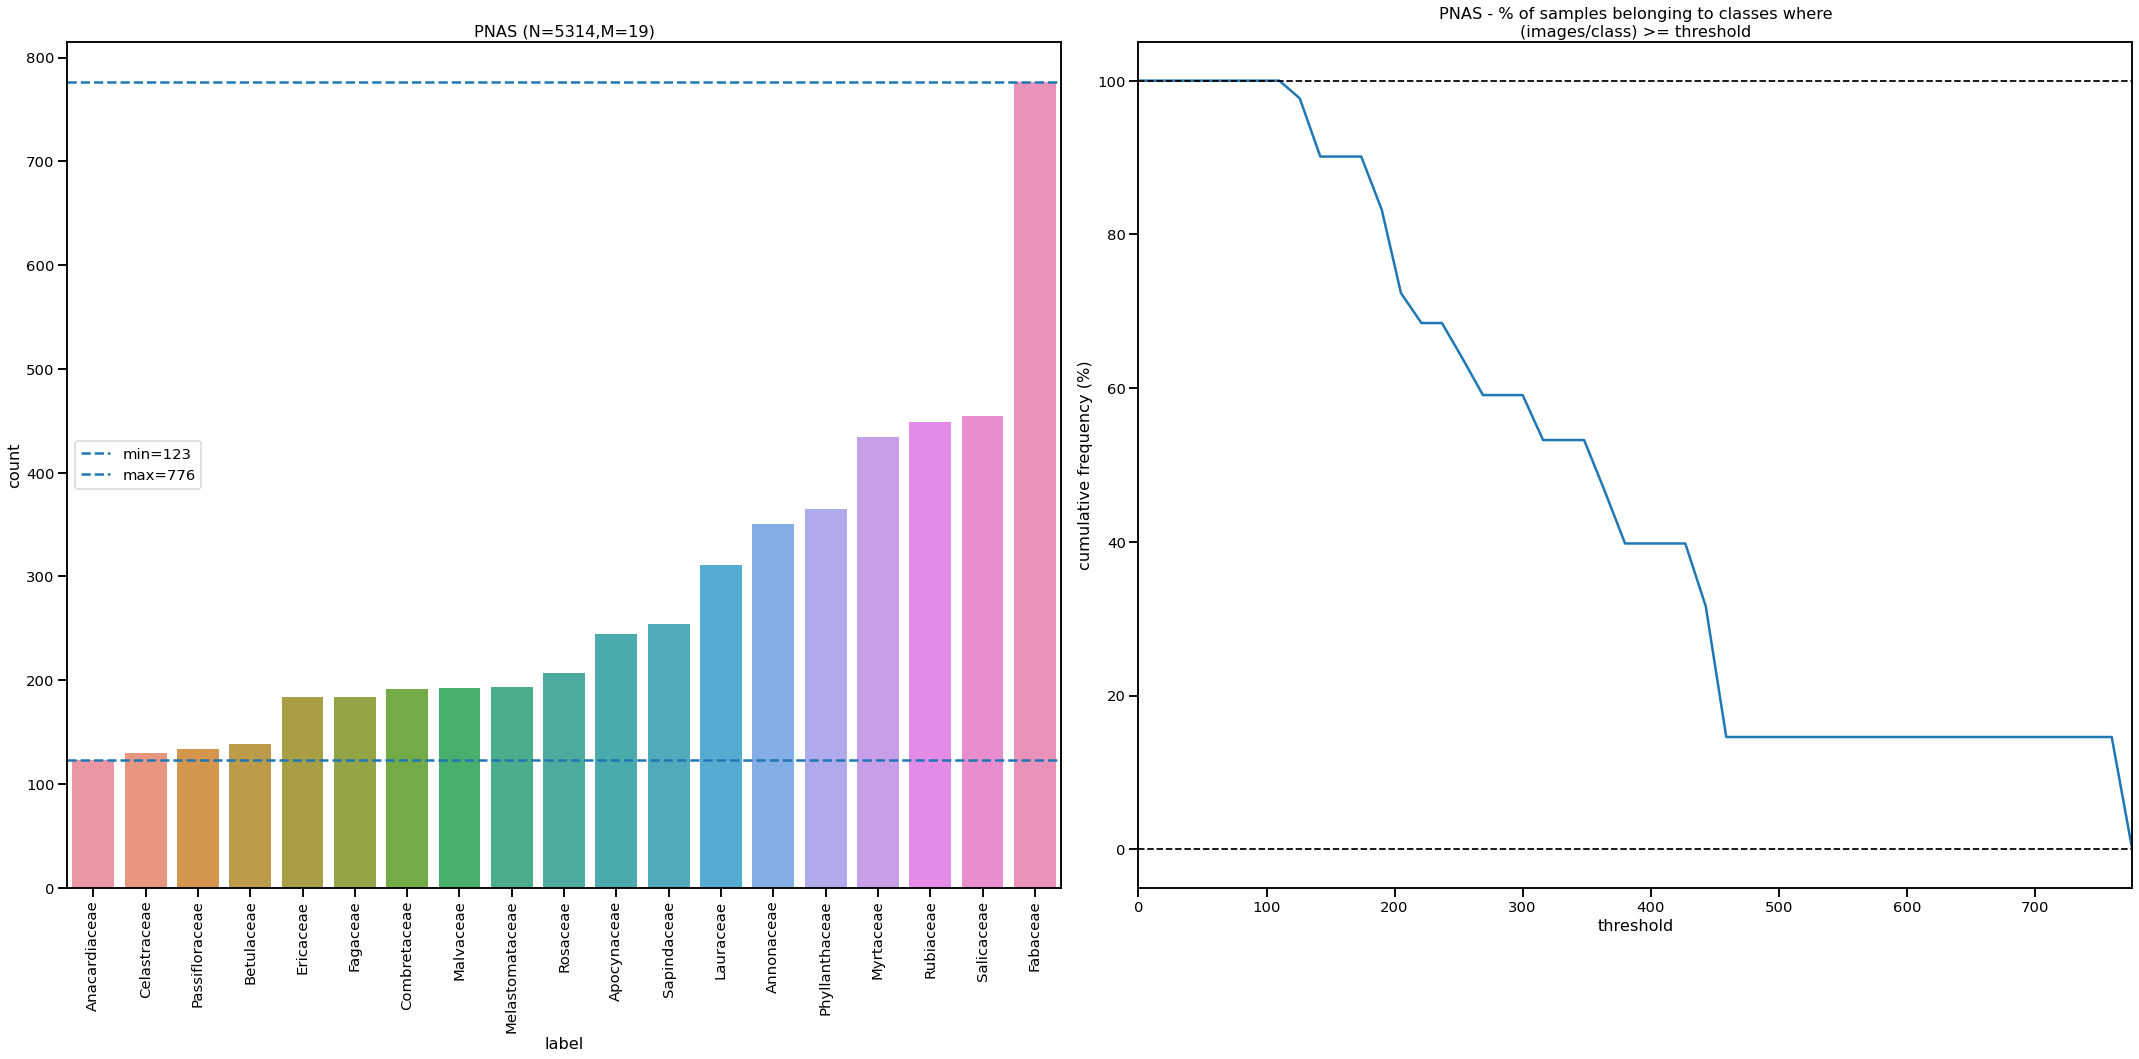

In [3]:
pnas = pnas_dataset.PNASDataset()

pnas.exclude_rare_classes(threshold=PARAMS['threshold'])
classes = list(set(pnas.classes)-set(PARAMS['exclude_classes']))
pnas, excluded_data_files = pnas.enforce_class_whitelist(class_names=classes)
encoder = base_dataset.LabelEncoder(pnas.classes)
pnas_metadata = pnas.get_instance_metadata()

fig, axes = plt.subplots(1,2,figsize=(30,15))
fig, ax0 = pnas_metadata.plot_class_distribution(ascending=True, ax=axes[0])
fig, ax1 = pnas_metadata.plot_class_percentiles(ascending=True, ax=axes[1])
plt.savefig(f'PNAS_v{pnas.__version__}_class_distributions.jpg')

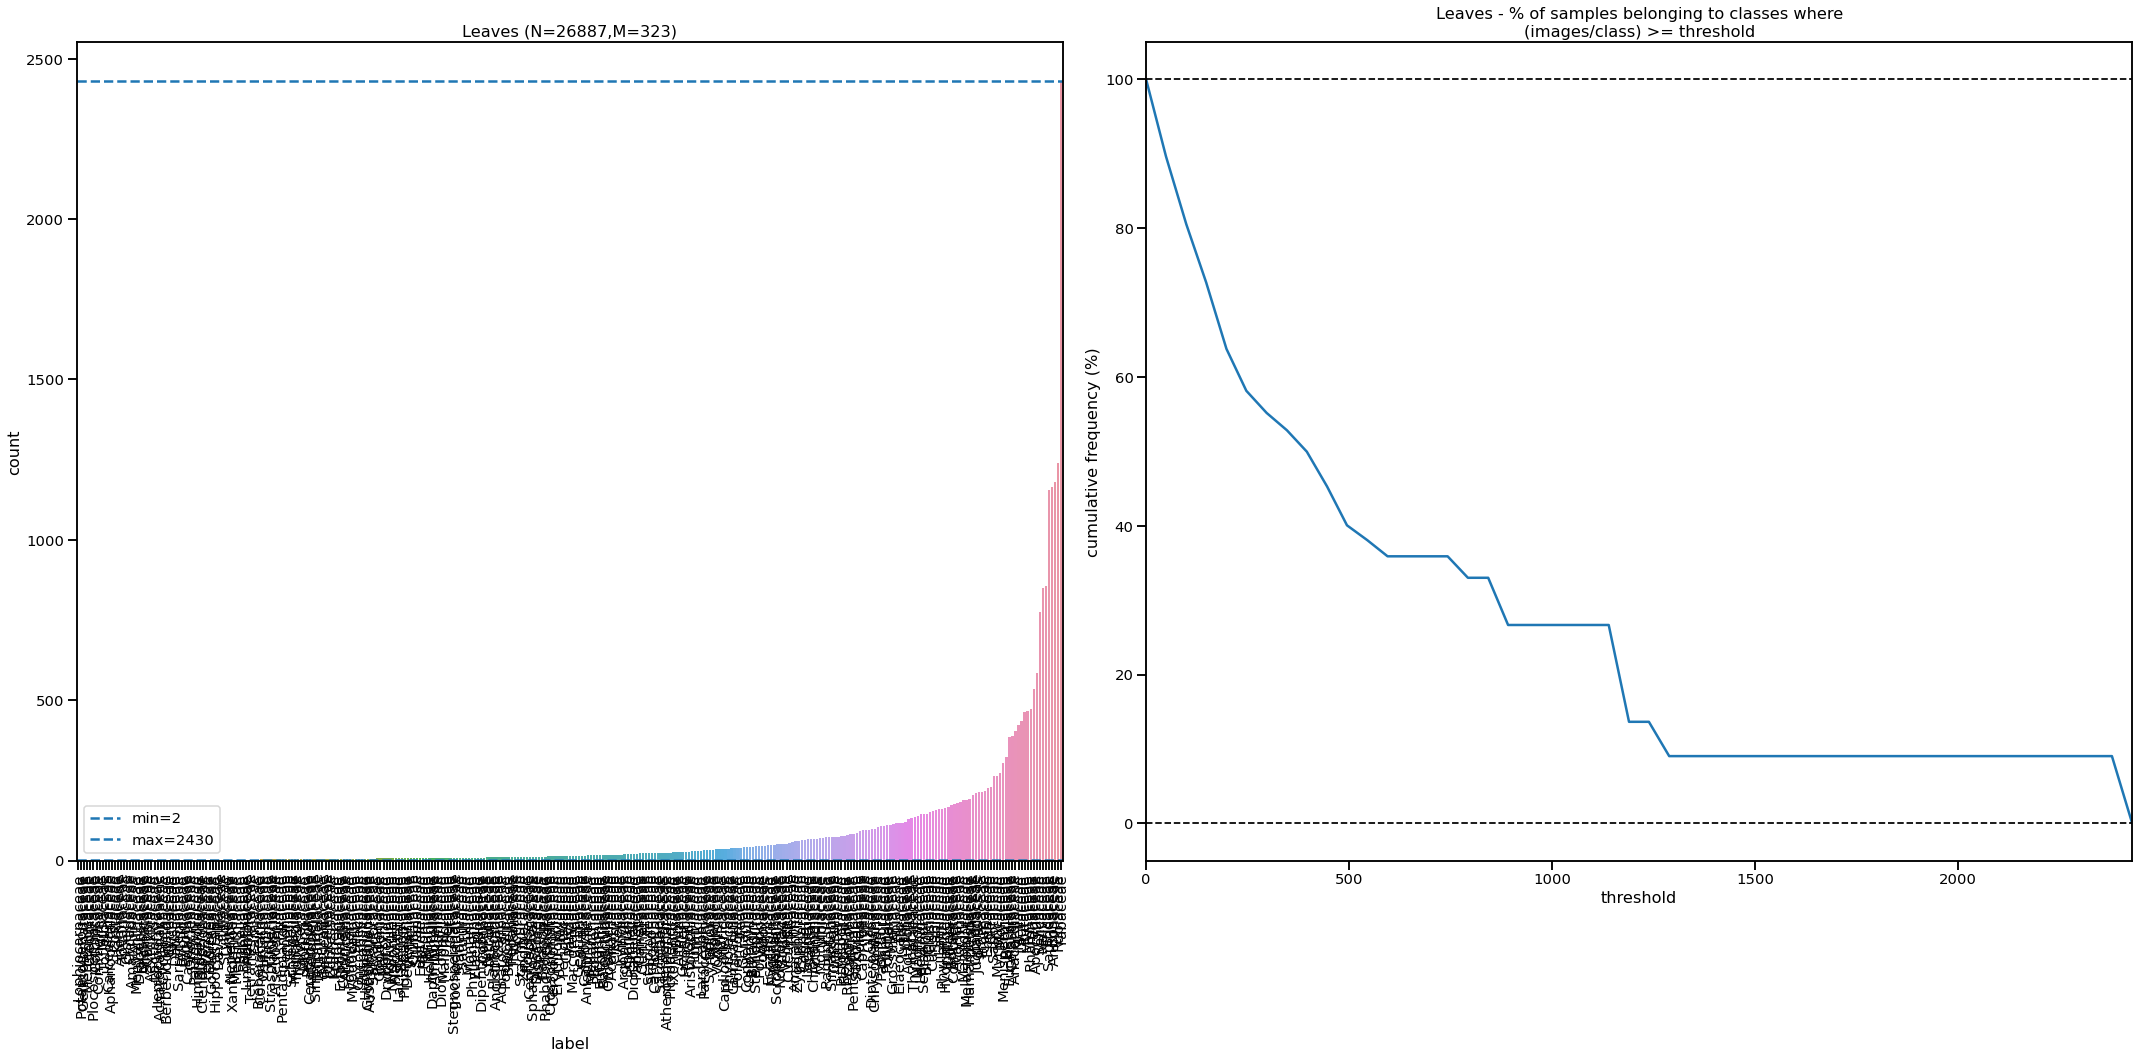

In [4]:
leaves = leaves_dataset.LeavesDataset()
leaves.exclude_rare_classes(threshold=PARAMS['threshold'])
classes = list(set(leaves.classes)-set(PARAMS['exclude_classes']))
leaves, excluded_data_files = leaves.enforce_class_whitelist(class_names=classes)
encoder = base_dataset.LabelEncoder(leaves.classes)
leaves_metadata = leaves.get_instance_metadata()

fig, axes = plt.subplots(1,2,figsize=(30,15))
fig, ax0 = leaves_metadata.plot_class_distribution(ascending=True, ax=axes[0])
fig, ax1 = leaves_metadata.plot_class_percentiles(ascending=True, ax=axes[1])

plt.savefig(f'Leaves_v{leaves.__version__}_class_distributions.jpg')

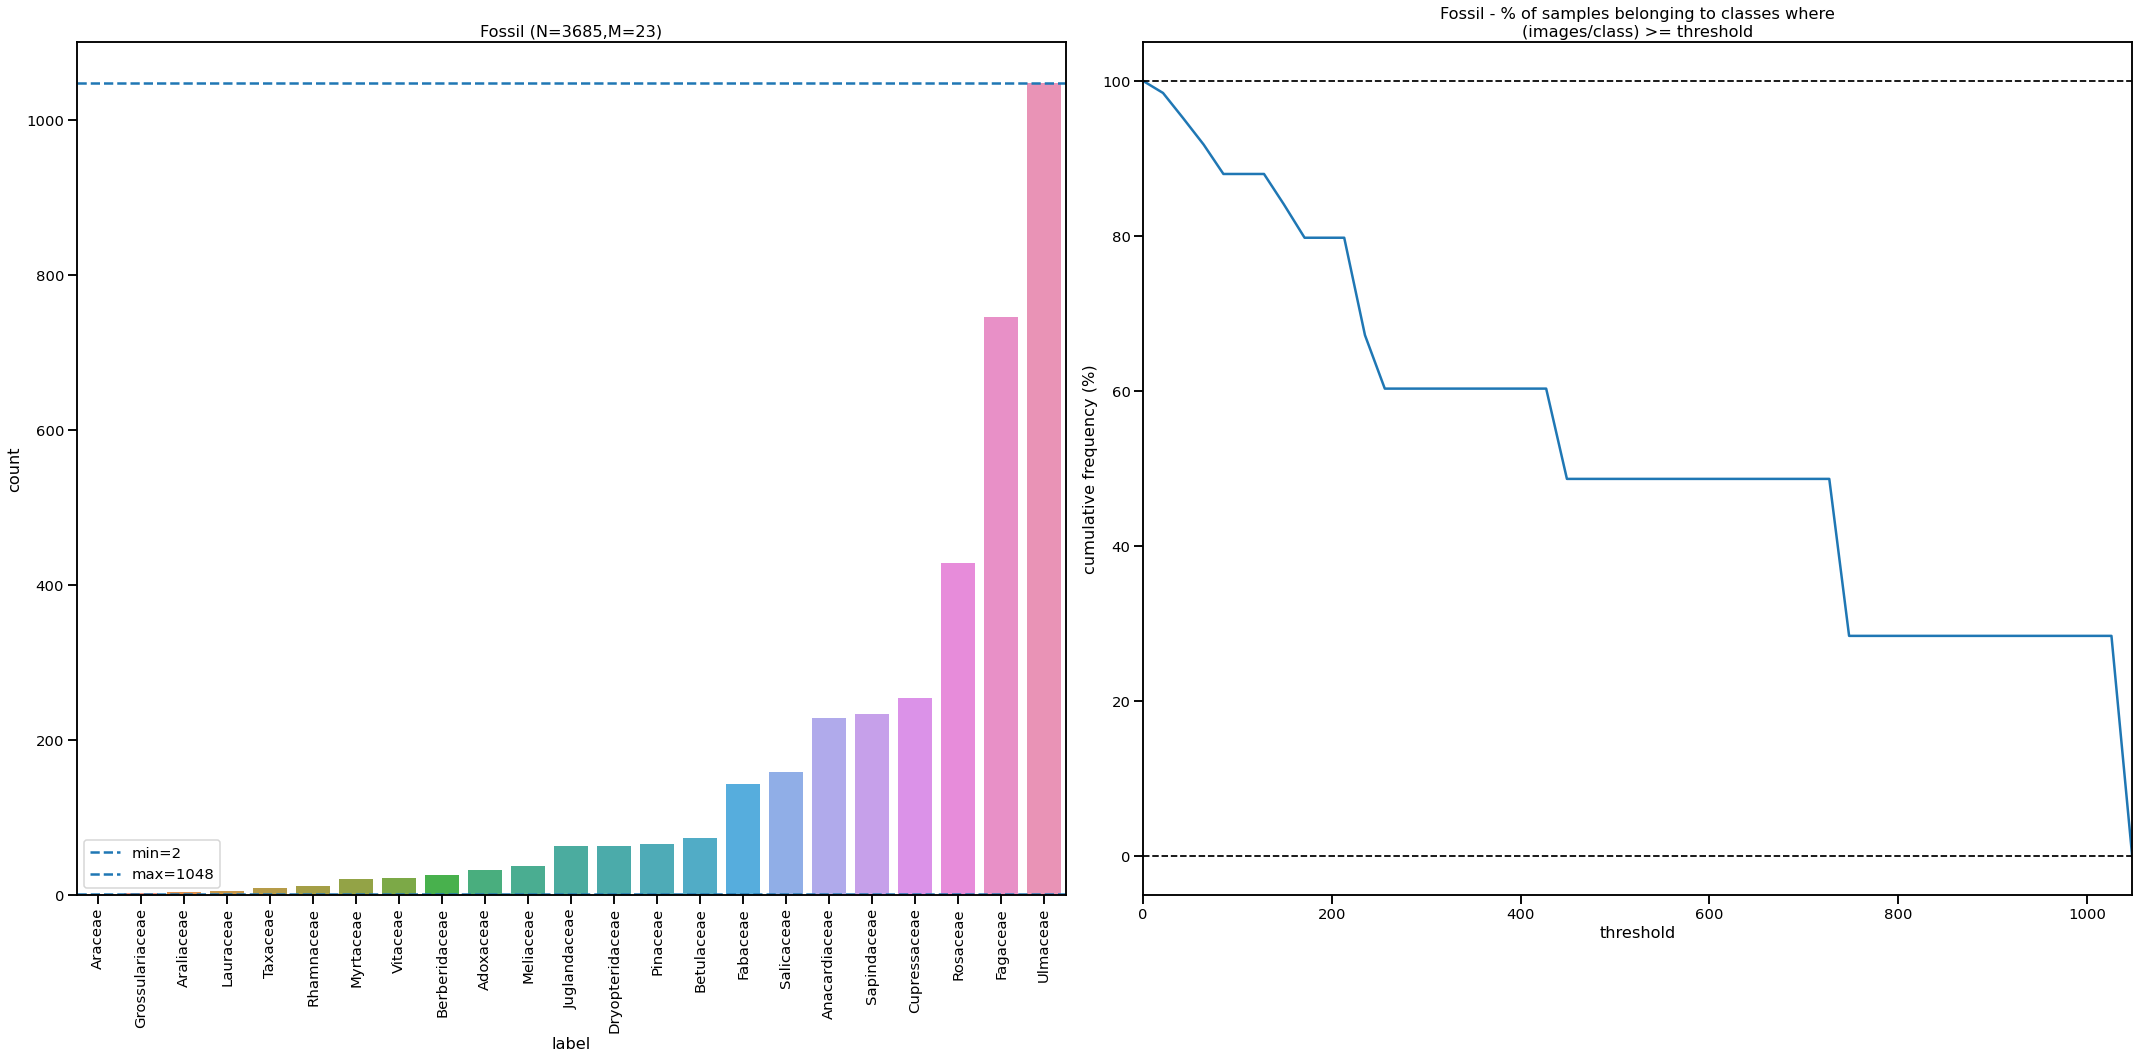

In [5]:
fossil = fossil_dataset.FossilDataset()

fossil = fossil_dataset.FossilDataset()
fossil.exclude_rare_classes(threshold=PARAMS['threshold'])
classes = list(set(fossil.classes)-set(PARAMS['exclude_classes']))
fossil, excluded_data_files = fossil.enforce_class_whitelist(class_names=classes)
encoder = base_dataset.LabelEncoder(fossil.classes)
fossil_metadata = fossil.get_instance_metadata()

fig, axes = plt.subplots(1,2,figsize=(30,15))
fig, ax0 = fossil_metadata.plot_class_distribution(ascending=True, ax=axes[0])
fig, ax1 = fossil_metadata.plot_class_percentiles(ascending=True, ax=axes[1])





# fig, axes = plt.subplots(1,2,figsize=(30,15))
# fig, ax0 = fossil.metadata.plot_class_distribution(ascending=True, ax=axes[0])
# fig, ax1 = fossil.metadata.plot_class_percentiles(ascending=True, ax=axes[1])
plt.savefig(f'Fossil_v{fossil.__version__}_class_distributions.jpg')

In [12]:
dataset_1 = leaves
dataset_2 = pnas

def dataset_class_intersections(dataset_1, dataset_2):
    print(dataset_1.name, 'classes only: ', len(set(dataset_1.classes) - set(dataset_2.classes)))
    print(dataset_2.name, 'classes only: ', len(set(dataset_2.classes) - set(dataset_1.classes)))
    dataset_1_2 = dataset_1 + dataset_2
    print(dataset_1_2.name, 'clsses: ', len(dataset_1_2.classes))
# set(fossil.classes).intersection(set(pnas.classes))


dataset_class_intersections(dataset_1=leaves, dataset_2=pnas)
dataset_class_intersections(dataset_1=fossil, dataset_2=pnas)


dataset_class_intersections(dataset_1=leaves, dataset_2=fossil)

Leaves classes only:  304
PNAS classes only:  0
Leaves+PNAS clsses:  323
Fossil classes only:  14
PNAS classes only:  10
Fossil+PNAS clsses:  33
Leaves classes only:  301
Fossil classes only:  1
Leaves+Fossil clsses:  324


In [2]:
from pyleaves.utils.callback_utils import BackupAndRestore

import arrow
import copy
from datetime import datetime, timedelta
import numpy as np
import neptune
import os
import random
from stuf import stuf
from pathlib import Path
os.environ["CUDA_VISIBLE_DEVICES"] = '5'
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except:
    print('setting memory growth failed, continuing anyway.')
random.seed(84)
np.random.seed(58)
tf.random.set_seed(34)
from tensorflow.keras import backend as K
from pyleaves.mains.baseline_train_pipeline import (build_model,
                                                    build_or_restore_model,
                                                    create_dataset,
                                                    load_data, 
                                                    prep_dataset, 
                                                    resize_image,
                                                    ImageLoggerCallback,
                                                    EarlyStopping, 
                                                    neptune_logger,
                                                    initialize_experiment,
                                                    restore_or_initialize_experiment)
                                                    
from pyleaves.datasets import leaves_dataset, fossil_dataset, pnas_dataset, base_dataset


import matplotlib.pyplot as plt
from pprint import pprint
##################################################
##################################################
def plot_batch(x, y=None, idx = None, encoder=None, rows=4, cols=2, figsize=(15,15)):
    assert rows*cols >= len(x), print('Not enough requested rows or columns to plot all images')
    
    x_norm = (x - x.numpy().min())/(x.numpy().max() - x.numpy().min())
    
    if encoder is not None:
        y = [encoder[i] for i in y.numpy()]
    if idx is not None:
        idx = idx.numpy()
        y = ['-'.join([str(idx[i]),y[i]]) for i in range(idx.shape[0])]
    
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.ravel()
    for i in range(x_norm.shape[0]): #len(axes)):
        axes[i].imshow(x_norm[i,...])
        if y is not None:
            axes[i].set_title(y[i])
            
    return fig, axes

# date_format = '%Y-%m-%d_%H-%M-%S'

# def initialize_experiment(PARAMS, experiment_start_time=None):
#     PARAMS['experiment_name'] = '_'.join([PARAMS['dataset_name'], PARAMS['model_name']])
#     PARAMS['experiment_dir'] = os.path.join(PARAMS['neptune_experiment_dir'], PARAMS['experiment_name'])

#     PARAMS['experiment_start_time'] = experiment_start_time or datetime.now().strftime(date_format)
#     PARAMS['log_dir'] = os.path.join(PARAMS['experiment_dir'], 'log_dir__'+PARAMS['experiment_start_time'])
#     PARAMS['model_dir'] = os.path.join(PARAMS['log_dir'],'model_dir')
#     PARAMS['saved_model_path'] = str(Path(PARAMS['model_dir']) / Path('saved_model'))
#     PARAMS['checkpoints_path'] = str(Path(PARAMS['model_dir']) / Path('checkpoints'))
    
# def restore_or_initialize_experiment(PARAMS, restore_last=False, prefix='log_dir__', verbose=0):
# #     date_format = '%Y-%m-%d_%H-%M-%S'
#     PARAMS = copy.deepcopy(PARAMS)
#     PARAMS['experiment_name'] = '_'.join([PARAMS['dataset_name'], PARAMS['model_name']])
#     PARAMS['experiment_dir'] = os.path.join(PARAMS['neptune_experiment_dir'], PARAMS['experiment_name'])

#     if restore_last:
#         experiment_files = [(exp_name.split(prefix)[-1], exp_name) for exp_name in os.listdir(PARAMS['experiment_dir'])]
#         keep_files = []
#         for i in range(len(experiment_files)):
#             exp = experiment_files[i]
#             try:
#                 keep_files.append((datetime.strptime(exp[0], date_format), exp[1]))
#                 if verbose >= 1: print(f'Found previous experiment {exp[1]}')
#             except ValueError:
#                 if verbose >=2: print(f'skipping invalid file {exp[1]}')
#                 pass
        
#         experiment_files = sorted(keep_files, key= lambda exp: exp[0])
#         if type(experiment_files)==list and len(experiment_files)>0:
#             experiment_file = experiment_files[-1]
#             PARAMS['experiment_start_time'] = experiment_file[0].strftime(date_format)
#             initialize_experiment(PARAMS, experiment_start_time=PARAMS['experiment_start_time'])
#             if verbose >= 1: print(f'Continuing experiment with start time =', PARAMS['experiment_start_time'])
#             return PARAMS
#         else:
#             print('No previous experiment in',PARAMS['experiment_dir'], 'with prefix',prefix)

#     PARAMS['experiment_start_time'] = datetime.now().strftime(date_format)
#     initialize_experiment(PARAMS, experiment_start_time=PARAMS['experiment_start_time'])
#     if verbose >= 1: print('Initializing new experiment at time:', PARAMS['experiment_start_time'] )
#     return PARAMS
    
##################################################
##################################################
##################################################

##################################################
##################################################
##################################################
    
    
PARAMS = {'neptune_project_name':'jacobarose/sandbox',
          'neptune_experiment_dir':'/media/data/jacob/sandbox_logs',
          'optimizer':'Adam',
          'loss':'categorical_crossentropy',
          'lr':1e-5,
          'color_mode':'grayscale',
          'num_channels':3,
          'BATCH_SIZE':8,
          'buffer_size':400,
          'num_epochs':150,
          'dataset_name':'Leaves',#'PNAS',
          'threshold':2,
          'frozen_layers':None,
          'model_name':'vgg16',#'resnet_50_v2',
          'splits':{'train':0.5,'validation':0.5},
          'seed':45}

PARAMS = stuf(PARAMS)

PARAMS['exclude_classes'] = ['notcataloged','notcatalogued', 'II. IDs, families uncertain', 'Unidentified']
PARAMS['regularization'] = {'l1':3e-4}
PARAMS['METRICS'] = ['accuracy','precision','recall']
PARAMS['target_size'] = (256,256)#(512,512)#(768,768)#(128,128)#
PARAMS['augmentations'] = [{'flip':1.0}]

##################################################
##################################################
##################################################

##################################################
##################################################
##################################################


PARAMS = restore_or_initialize_experiment(PARAMS, restore_last=True, prefix='log_dir__', verbose=2)
pprint(PARAMS)

##################################################
##################################################
from pyleaves.utils import ensure_dir_exists

neptune.init(project_qualified_name=PARAMS['neptune_project_name'])
neptune.create_experiment(name=PARAMS['experiment_name']+'-'+str(dict(PARAMS['splits'])), params=PARAMS)


ensure_dir_exists(PARAMS['log_dir'])
ensure_dir_exists(PARAMS['model_dir'])
neptune.append_tag(PARAMS['dataset_name'])
neptune.append_tag(PARAMS['model_name'])
neptune.append_tag(str(PARAMS['target_size']))
neptune.append_tag(PARAMS['num_channels'])
neptune.append_tag(PARAMS['color_mode'])
K.clear_session()
tf.random.set_seed(PARAMS['seed'])

##################################################
##################################################



# PARAMS['experiment_name'] = '_'.join([PARAMS['dataset_name'], PARAMS['model_name']])
# PARAMS['experiment_dir'] = os.path.join(PARAMS['neptune_experiment_dir'], PARAMS['experiment_name'])
# PARAMS['log_dir'] = os.path.join(PARAMS['experiment_dir'], 'log_dir__'+PARAMS['experiment_start_time'])
# PARAMS['model_dir'] = os.path.join(PARAMS['log_dir'],'model_dir')
# from pathlib import Path
# PARAMS['saved_model_path'] = str(Path(PARAMS['model_dir']) / Path('saved_model'))
# PARAMS['checkpoints_path'] = str(Path(PARAMS['model_dir']) / Path('checkpoints'))
# PARAMS['checkpoints_path'] = str(Path(PARAMS['checkpoints_dir']) / Path(PARAMS['model_name']+'.ckpt-{epoch}'))
# pprint(PARAMS)

# restore_or_initialize_experiment(PARAMS, restore_last=True, prefix='log_dir_categorical_crossentropy_')#False)



train_dataset, validation_dataset, data_files, excluded = create_dataset(dataset_name=PARAMS['dataset_name'],
                                                               threshold=PARAMS['threshold'],
                                                               batch_size=PARAMS['BATCH_SIZE'],
                                                               buffer_size=PARAMS['buffer_size'],
                                                               exclude_classes=PARAMS['exclude_classes'],
                                                               target_size=PARAMS['target_size'],
                                                               num_channels=PARAMS['num_channels'],
                                                               color_mode=PARAMS['color_mode'],
                                                               splits=PARAMS['splits'],
                                                               augmentations=PARAMS['augmentations'],
                                                               seed=PARAMS['seed'])

PARAMS['num_classes'] = data_files.num_classes
PARAMS['splits_size'] = {'train':{},
                   'validation':{}}
PARAMS['splits_size']['train'] = int(data_files.num_samples*PARAMS['splits']['train'])
PARAMS['splits_size']['validation'] = int(data_files.num_samples*PARAMS['splits']['validation'])

PARAMS['steps_per_epoch'] = PARAMS['splits_size']['train']//PARAMS['BATCH_SIZE']
PARAMS['validation_steps'] = PARAMS['splits_size']['validation']//PARAMS['BATCH_SIZE']

neptune.set_property('num_classes',PARAMS['num_classes'])
neptune.set_property('steps_per_epoch',PARAMS['steps_per_epoch'])
neptune.set_property('validation_steps',PARAMS['validation_steps'])

# TODO: log encoder contents as dict
encoder = base_dataset.LabelEncoder(data_files.classes)

PARAMS['base_learning_rate'] = PARAMS['lr']
PARAMS['input_shape'] = (*PARAMS['target_size'],PARAMS['num_channels'])


##################################################
##################################################
# print(len(list(set(data_files.classes))))
# print(len(list(set(data_files.classes) - {'notcataloged','notcatalogued'})))
# excluded.data

/media/data/conda/jacob/envs/pyleaves2/lib/python3.7/site-packages/scikitplot/plotters.py:37: DeprecationWarning: This module was deprecated in version 0.3.0 and its functions are spread throughout different modules. Please check the documentation and update your function calls as soon as possible. This module will be removed in 0.4.0
  DeprecationWarning)


No previous experiment in /media/data/jacob/sandbox_logs/Leaves_vgg16 with prefix log_dir__
Initializing new experiment at time: 2020-07-23_09-35-20
{'BATCH_SIZE': 8,
 'METRICS': ['accuracy', 'precision', 'recall'],
 'augmentations': [{'flip': 1.0}],
 'buffer_size': 400,
 'checkpoints_path': '/media/data/jacob/sandbox_logs/Leaves_vgg16/log_dir__2020-07-23_09-35-20/model_dir/checkpoints',
 'color_mode': 'grayscale',
 'dataset_name': 'Leaves',
 'exclude_classes': ['notcataloged', 'notcatalogued'],
 'experiment_dir': '/media/data/jacob/sandbox_logs/Leaves_vgg16',
 'experiment_name': 'Leaves_vgg16',
 'experiment_start_time': '2020-07-23_09-35-20',
 'frozen_layers': None,
 'log_dir': '/media/data/jacob/sandbox_logs/Leaves_vgg16/log_dir__2020-07-23_09-35-20',
 'loss': 'categorical_crossentropy',
 'lr': 1e-05,
 'model_dir': '/media/data/jacob/sandbox_logs/Leaves_vgg16/log_dir__2020-07-23_09-35-20/model_dir',
 'model_name': 'vgg16',
 'neptune_experiment_dir': '/media/data/jacob/sandbox_logs',


https://ui.neptune.ai/jacobarose/sandbox/e/SAN-583


In [ ]:
strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
with strategy.scope():
    model = build_model(PARAMS)

# model = build_or_restore_model(PARAMS)
model.summary(print_fn=lambda x: neptune.log_text('model_summary', x))
pprint(PARAMS)

backup_callback = BackupAndRestore(PARAMS['checkpoints_path'])
backup_callback.set_model(model)
callbacks = [neptune_logger,
             backup_callback,
             EarlyStopping(monitor='val_loss', patience=25, verbose=1, restore_best_weights=True)]#,
#              ImageLoggerCallback(data=train_dataset, freq=1000, max_images=-1, name='train', encoder=encoder),
#              ImageLoggerCallback(data=validation_dataset, freq=1000, max_images=-1, name='val', encoder=encoder),
#              tf.keras.callbacks.ModelCheckpoint(filepath=PARAMS['saved_model_path'],#PARAMS['checkpoints_path'],
#                                                 monitor='val_loss', 
#                                                 verbose=1, 
#                                                 save_best_only=True)]#False)]


history = model.fit(train_dataset,
                    epochs=PARAMS['num_epochs'],
                    callbacks=callbacks,
                    validation_data=validation_dataset,
                    shuffle=True,
                    steps_per_epoch=PARAMS['steps_per_epoch'],
                    validation_steps=PARAMS['validation_steps'])
#                     initial_epoch=0,
# TODO: Change build_model to build_or_load_model
# TODO: Add line to save model weights
model.save(PARAMS['saved_model_path'] + '-stage 1')
for k,v in PARAMS.items():
    neptune.set_property(str(k),str(v))
    
    
# neptune.

{'BATCH_SIZE': 8,
 'METRICS': ['accuracy', 'precision', 'recall'],
 'augmentations': [{'flip': 1.0}],
 'base_learning_rate': 1e-05,
 'buffer_size': 400,
 'checkpoints_path': '/media/data/jacob/sandbox_logs/Leaves_vgg16/log_dir__2020-07-23_09-35-20/model_dir/checkpoints',
 'color_mode': 'grayscale',
 'dataset_name': 'Leaves',
 'exclude_classes': ['notcataloged', 'notcatalogued'],
 'experiment_dir': '/media/data/jacob/sandbox_logs/Leaves_vgg16',
 'experiment_name': 'Leaves_vgg16',
 'experiment_start_time': '2020-07-23_09-35-20',
 'frozen_layers': None,
 'input_shape': (256, 256, 3),
 'log_dir': '/media/data/jacob/sandbox_logs/Leaves_vgg16/log_dir__2020-07-23_09-35-20',
 'loss': 'categorical_crossentropy',
 'lr': 1e-05,
 'model_dir': '/media/data/jacob/sandbox_logs/Leaves_vgg16/log_dir__2020-07-23_09-35-20/model_dir',
 'model_name': 'vgg16',
 'neptune_experiment_dir': '/media/data/jacob/sandbox_logs',
 'neptune_project_name': 'jacobarose/sandbox',
 'num_channels': 3,
 'num_classes': 323,


In [ ]:
# pprint(vars(history))

# pprint(history.history)

# # new_model = keras.models.load_model(PARAMS['checkpoints_path'])

# # print(tf.train.latest_checkpoint(PARAMS['checkpoints_path']))
# print(tf.train.latest_checkpoint(PARAMS['model_dir']))

# os.listdir(PARAMS['checkpoints_dir'])



In [ ]:
# dataset, data_files = load_data(dataset_name=PARAMS['dataset_name'], splits=PARAMS['splits'], threshold=PARAMS['threshold'], seed=PARAMS['seed'], shuffle_train=False)
# train_data = prep_dataset(dataset['train'],
#                           batch_size=PARAMS['BATCH_SIZE'],
#                           buffer_size=PARAMS['buffer_size'],#int(data_files.num_samples*splits['train']),
#                           shuffle=True,
#                           target_size=PARAMS['target_size'],
#                           num_channels=PARAMS['num_channels'],
#                           color_mode=PARAMS['color_mode'],
#                           num_classes=data_files.num_classes,
#                           augmentations=PARAMS['augmentations'],
#                           aug_prob=PARAMS['aug_prob'],
#                           training=True,
#                           seed=PARAMS['seed'])

# from functools import partial

# train_resize = partial(resize_image, shape=(*PARAMS['target_size'], PARAMS['num_channels']), training=True, seed=PARAMS['seed'])
# val_resize = partial(resize_image, shape=(*PARAMS['target_size'], PARAMS['num_channels']), training=False, seed=PARAMS['seed'])


# train_data = dataset['train'].enumerate().take(2).repeat(8)
# train_data = train_data.map(lambda i,xy: (i, (train_resize(xy[0]), xy[1])),
#                       num_parallel_calls=-1).batch(16)


# val_data = dataset['validation'].enumerate().take(2).repeat(8)
# val_data = val_data.map(lambda i,xy: (i, (val_resize(xy[0]), xy[1])),
#                       num_parallel_calls=-1).batch(16)


# idx,(x,y) = next(iter(train_data))
# fig, axes = plot_batch(x, y, idx=idx, encoder=data_files.classes, rows=4, cols=4)
# plt.suptitle('train')

# idx,(x,y) = next(iter(val_data))
# fig, axes = plot_batch(x, y, idx=idx, encoder=data_files.classes, rows=4, cols=4)
# plt.suptitle('validation')